In [1]:
from __future__ import division
import torch.optim as optim
from utils import *
from basic_structure import D_GCN, C_GCN, K_GCN,IGNNK
import geopandas as gp
import matplotlib as mlt

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)
import os
from PIL import Image
import gc 
import pandas as pd
from datetime import date
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
import scipy.sparse as sp
from sklearn.preprocessing import minmax_scale
import os
import copy

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### create graph

In [2]:
arr=os.listdir('/home/yongcan/GDOT/clustering_kriging/train_by_cluster')
namelist=[]
for station in arr:
    station=station[:-4]
    namelist.append(station)
cluster=pd.read_csv('/home/yongcan/GDOT/clustering_kriging/clustering_result_july13.csv')
cluster=cluster[cluster['stationname'].isin(namelist)].reset_index()
cluster_num = len(set(cluster.cluster.values))
namelist=list(cluster['stationname'].values)
print('all has {} cluster numbers', cluster_num)
    
print('input stationname has',len(namelist))

all has {} cluster numbers 181
input stationname has 455


In [4]:
def create_stationname(filename,namelist):
    stations = pd.read_csv(filename)['Y0']
    stations = list(stations)

    stationname=[]
    crdinstation=[]
    for item in namelist:
        if item[0:8]  in stations:
            stationname.append(item)
            crdinstation.append(item[0:8])
        else:
            pass
    
    crdinstation=list(set(crdinstation))
    print('stationname has ',len(stationname))
    print('coordinate locations has ',len(crdinstation))

    return stationname, crdinstation 

def create_source(stationname, foldername):
    X=[]
    for station in stationname:
        values=[]
        fileaddress=foldername+station+'.csv'
        station_df=pd.read_csv(fileaddress,low_memory=False)
        values += station_df['Volume'].values.tolist()
        X.append(values)
    
    
    return X


In [5]:
stationname, crdinstation = create_stationname('/home/yongcan/GDOT/clustering_kriging/distancewith0.csv',namelist)
X= create_source(stationname, '/home/yongcan/GDOT/clustering_kriging/train_by_cluster/')


stationname has  455
coordinate locations has  240


In [6]:
# Define the split ratio
split_ratio = 1

# Initialize lists to store training and testing sets
training_set_ = []
testing_set_ = []

# Iterate through each row in the original array
for row in X:
    num_elements = len(row)
    split_point = int(num_elements * split_ratio)
    
    # Split the row's elements into training and testing
    training_elements = row[:split_point]
    testing_elements = row[split_point:]
    
    # Append the training and testing elements to the respective sets
    training_set_.append(training_elements)
    testing_set_.append(testing_elements)

# Convert the lists of lists to NumPy arrays
training_ = np.array(training_set_)
testing_ = np.array(testing_set_)

# Check the shapes of the training and testing sets
print("Training Set Shape:", training_.shape)
print("Testing Set Shape:", testing_.shape)

Training Set Shape: (455,)
Testing Set Shape: (455, 0)


/tmp/ipykernel_22395/3768083508.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_ = np.array(training_set_)


##### Proximity features

In [3]:
def generateDF(path_distance,path_coordinates,namelist):
    df = pd.read_csv(path_distance) 
    names1=list(df['Y0'])
    df=df.drop(columns=['Y0'])
    df.columns=names1
    CO=pd.read_csv(path_coordinates)
    df['stationname']=CO.ID
    df=df.set_index('stationname')
    df=df.loc[namelist]
    df=df[namelist]
    
    return df

In [4]:
def generate_adj(stationname,DF):

    matrix=pd.DataFrame(columns=stationname,index=stationname)


    for station in stationname:
        for STATION in stationname:
            matrix.loc[station,STATION]=DF.loc[station[0:8],STATION[0:8]]

    MAX=matrix.max()
    matrix =matrix/MAX
    matrix = np.exp(-matrix.astype(float))
    matrix=matrix.apply(pd.Series.nlargest, axis=1, n=493)
    matrix=matrix.fillna(0)
    matrix=matrix.values

    adj = np.zeros_like(matrix)
    for i in range(len(matrix)):
        ind=np.argsort(matrix[i])[::-1][0:6]
        adj[i][ind]=1

    print('The adjacent matrix shape is', adj.shape )
    
    return adj,matrix

In [8]:
def get_M(matrix,k):
    
    M = np.zeros_like(matrix)
    M = torch.Tensor(M)
    matrix=torch.Tensor(matrix)
    values, index=torch.topk(matrix,k)
    function = torch.nn.Softmax(dim=1)
    values = function(values)
    for i in range(len(M)):
        ind=index[i]
        M[i][ind]=values[i]

    
    return M.to(device)

In [9]:
DF= generateDF(path_distance='/home/yongcan/GDOT/clustering_kriging/distancewith0.csv',path_coordinates='/home/yongcan/GDOT/clustering_kriging/station_coordinates.csv',namelist=crdinstation)
adj,A= generate_adj(stationname,DF)
M = get_M(A,12)
M

The adjacent matrix shape is (455, 455)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

### Import the training data


#### Model 

In [5]:
class D_GCN(nn.Module):
    """
    Neural network block that applies a diffusion graph convolution to sampled location
    """       
    def __init__(self, in_channels, out_channels, orders, activation = 'relu'): 
        """
        :param in_channels: Number of time step.
        :param out_channels: Desired number of output features at each node in
        each time step.
        :param order: The diffusion steps.
        """
        super(D_GCN, self).__init__()
        self.orders = orders
        self.activation = activation
        self.num_matrices = 2 * self.orders + 1
        self.Theta1 = nn.Parameter(torch.FloatTensor(in_channels * self.num_matrices,
                                             out_channels))
        self.bias = nn.Parameter(torch.FloatTensor(out_channels))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Theta1.shape[1])
        self.Theta1.data.uniform_(-stdv, stdv)
        stdv1 = 1. / math.sqrt(self.bias.shape[0])
        self.bias.data.uniform_(-stdv1, stdv1)
        
    def _concat(self, x, x_):
        x_ = x_.unsqueeze(0)
        return torch.cat([x, x_], dim=0)
        
    def forward(self, X, A_q, A_h):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps)
        :A_q: The forward random walk matrix (num_nodes, num_nodes)
        :A_h: The backward random walk matrix (num_nodes, num_nodes)
        :return: Output data of shape (batch_size, num_nodes, num_features)
        """
        batch_size = X.shape[0] # batch_size
        num_node = X.shape[1]
        input_size = X.size(2)  # time_length
        supports = []
        supports.append(A_q)
        supports.append(A_h)
        
        x0 = X.permute(1, 2, 0) #(num_nodes, num_times, batch_size)
        x0 = torch.reshape(x0, shape=[num_node, input_size * batch_size])
        x = torch.unsqueeze(x0, 0)
        for support in supports:
            x1 = torch.mm(support, x0)
            x = self._concat(x, x1)
            for k in range(2, self.orders + 1):
                x2 = 2 * torch.mm(support, x1) - x0
                x = self._concat(x, x2)
                x1, x0 = x2, x1
                
        x = torch.reshape(x, shape=[self.num_matrices, num_node, input_size, batch_size])
        x = x.permute(3, 1, 2, 0)  # (batch_size, num_nodes, input_size, order)
        x = torch.reshape(x, shape=[batch_size, num_node, input_size * self.num_matrices])         
        x = torch.matmul(x, self.Theta1)  # (batch_size * self._num_nodes, output_size)     
        x += self.bias
        if self.activation == 'relu':
            x = F.relu(x)
        elif self.activation == 'selu':
            x = F.selu(x)   
            
        return x

In [6]:
def calculate_random_walk_matrix(adj_mx):
    """
    Returns the random walk adjacency matrix. This is for D_GCN
    """
    adj_mx = sp.coo_matrix(adj_mx)
    d = np.array(adj_mx.sum(1))
    d_inv = np.power(d, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat_inv = sp.diags(d_inv)
    random_walk_mx = d_mat_inv.dot(adj_mx).tocoo()
    return random_walk_mx.toarray()

In [7]:
class DGCN(nn.Module):
    """
    GNN on ST datasets to reconstruct the datasets
   x_s
    |GNN_3
   H_2 + H_1
    |GNN_2
   H_1
    |GNN_1
  x^y_m     
    """
    def __init__(self, h, y,z,w, k): 
        super(DGCN, self).__init__()
        self.time_dimension = h
        self.hidden_dimension1=y
        self.hidden_dimension2 = z
        self.hidden_dimension3 = w
        self.order = k

        self.GNN1 = D_GCN(self.time_dimension, self.hidden_dimension1, self.order) #72
        self.GNN2 = D_GCN(self.hidden_dimension1, self.hidden_dimension2, self.order)
        self.GNN3 = D_GCN(self.hidden_dimension2, self.hidden_dimension3, self.order)

        self.GNN4 = D_GCN(self.hidden_dimension3, self.hidden_dimension2, self.order)
        self.GNN5 = D_GCN(self.hidden_dimension2, self.hidden_dimension1, self.order)
        self.GNN6 = D_GCN(self.hidden_dimension1, self.time_dimension, self.order, activation = 'linear')

        #self.cross_attn = nn.MultiheadAttention(embed_dim=z, num_heads=8)

    def forward(self, X, A_q, A_h):
        """
        :param X: Input data of shape (batch_size, num_timesteps, num_nodes)
        :A_q: The forward random walk matrix (num_nodes, num_nodes)
        :A_h: The backward random walk matrix (num_nodes, num_nodes)
        :return: Reconstructed X of shape (batch_size, num_timesteps, num_nodes)
        """  
        X_S = X.permute(0, 2, 1) # to correct the input dims 
        
        X_s1 = self.GNN1(X_S, A_q, A_h)#y
        X_s2 = self.GNN2(X_s1, A_q, A_h)#z
        X_s3 = self.GNN3(X_s2, A_q, A_h)#w

        #X_s2,_= self.cross_attn(X_s2,X_s2,X_s1)
        
        X_s4 = self.GNN4(X_s3, A_q, A_h)+X_s2 #z
        X_s5 = self.GNN5(X_s4, A_q, A_h)+X_s1#y
        X_s6 = self.GNN6(X_s5, A_q, A_h)+X_S#h


        X_res = X_s6.permute(0, 2, 1)
               
        return  X_res

#### 训练

In [8]:
z = 16 #hidden dimension for graph convolution
K = 2 #If using diffusion convolution, the actual diffusion convolution step is K+1 ##try more Convolution 
h = 288 #Sampled time period to be masked 
y= 72
w=144
batch_size = 64
learning_rate = 0.0001
Max_episode = 100
cluster_num = len(set(cluster.cluster.values))
corrupted_ratio = 0.8

In [391]:
DGCN = DGCN(h,y,z,w,K) 
DGCN.to(device)


DGCN(
  (GNN1): D_GCN()
  (GNN2): D_GCN()
  (GNN3): D_GCN()
  (GNN4): D_GCN()
  (GNN5): D_GCN()
  (GNN6): D_GCN()
)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Get the number of parameters in the model
num_params = count_parameters(DGCN)
print(f'The model has {num_params} parameters.')

NameError: name 'self' is not defined

In [392]:
def insertsection(sequence):
    A=sequence.copy()
    win_num = 5#random.randint(0,5)
    inx = random.sample(range(0,len(A)-5),win_num)
    slices= random.choice([5,10,20])
    for idx in inx:
        for i in range(slices):
            scale = round(random.uniform(0.4, 0.6),1)
            A[idx:idx+i+1] = [x * scale for x in A[idx:idx+i+1]]
            #A[idx:idx+i]=A[idx:idx+i]*scale
   
    return A

In [393]:
def insertpoint(sequence):
    A=sequence.copy()
    win_num =random.randint(10,30)
    inx = random.sample(range(0,len(A)-5),win_num)
    for idx in inx:
        #sequence[idx:idx+5] =0#sequence[idx:idx+5]*0.4
        scale = round(random.uniform(0, 0.4),1)
        A[idx]=A[idx]*scale
    
    return A
    

In [394]:
def insert_zero(sequence):
    A=sequence.copy()
    win_num = random.randint(0,5)
    inx = random.sample(range(0,len(A)-5),win_num)
    slices= random.choice([5,10,20])
    for idx in inx:
        A[idx:idx+slices] = [x * 0 for x in A[idx:idx+slices]]
       # A[idx:idx+slices]=A[idx:idx+slices]*0
   
    return A

In [395]:
def introduce_error(sequence):
    A = sequence.copy()
    err_id= random.randint(0,2)
    if err_id ==0:
        A = insertpoint(A)
    elif err_id ==1:
        A = insertsection(A)
    elif err_id == 2:
        A = insert_zero(A)
    else:
        A = A

    return A

In [396]:
criterion = nn.MSELoss()
optimizer = optim.Adam(DGCN.parameters(), lr=learning_rate)
losslist=[]
for epoch in range(Max_episode):
    loss_epoch=0
    DGCN.train()
   
    for j in list(set(cluster['cluster'].values)):
        CLUSTER = cluster.loc[cluster['cluster'] == j]    
        know_nodes = list(CLUSTER.index)
        clustered_nodes = [training_[n] for n in know_nodes]
        
        X_= np.array(clustered_nodes).astype(np.float32)
        training_set=X_.transpose()
        E_maxvalue = training_set.max()
        label_set=X_.transpose().copy()
      

        for i in range(int(training_set.shape[0]//(h * batch_size))): 
            t_random = np.random.randint(0, high=(training_set.shape[0] - h), size=batch_size, dtype='l')


            feed_batch_tr = []
            feed_batch_lb = []
            
            num_error_batches = int(batch_size * corrupted_ratio )
            error_batch_indices = random.sample(range(batch_size), num_error_batches)
            for q in range(batch_size):
                if q in error_batch_indices:
                        node= random.randint(0, len(know_nodes) - 1)
                        training_set[t_random[q]: t_random[q] + h, node]= insertsection(training_set[t_random[q]: t_random[q] + h, :].transpose()[node])
                        
                #training_set[t_random[q]: t_random[q] + h, :][:, mask_node]= introduce_error(training_set[t_random[q]: t_random[q] + h, :][:, mask_node])
               # training_set[t_random[q]: t_random[q] + h, :]= introduce_error(training_set[t_random[q]: t_random[q] + h, :])
               
                feed_batch_tr.append(training_set[t_random[q]: t_random[q] + h, :])
                feed_batch_lb.append(label_set[t_random[q]: t_random[q] + h, :])
            
           # inputs = np.array(feed_batch_lb)
            inputs = np.array(feed_batch_tr)
            labels = np.array(feed_batch_lb)
            Mf_inputs = inputs/E_maxvalue
            Mf_inputs = torch.from_numpy(Mf_inputs.astype('float32')).to(device)cpu
          

            
            A_dynamic = adj[list(know_nodes), :][:, list(know_nodes)] 
            A_q = torch.from_numpy((calculate_random_walk_matrix(A_dynamic).T).astype('float32')).to(device)
            A_h = torch.from_numpy((calculate_random_walk_matrix(A_dynamic.T).T).astype('float32')).to(device)

        
            node_label = torch.from_numpy(labels).to(device)
        
            optimizer.zero_grad()

            X_res = DGCN(Mf_inputs, A_q, A_h)
            X_res =X_res * E_maxvalue
            loss_ = nn.MSELoss()(X_res.reshape(-1),node_label.reshape(-1))
            KL_loss = F.kl_div(F.log_softmax(X_res, dim=1), F.softmax(node_label, dim=1), reduction='batchmean')
            loss = loss_+0.01*KL_loss
        
            loss.backward()
            optimizer.step()  
            loss_epoch += loss

    print('the loss is {} at epoch {}'.format(loss,epoch))
    losslist.append(loss.detach().cpu().numpy())
    

idx = losslist == min(losslist)
print('Best model result:',np.array(losslist)[idx])

the loss is 6998.8505859375 at epoch 0
the loss is 6145.68359375 at epoch 1
the loss is 4852.0830078125 at epoch 2
the loss is 4830.439453125 at epoch 3
the loss is 4222.44677734375 at epoch 4
the loss is 4126.82666015625 at epoch 5
the loss is 3260.475830078125 at epoch 6
the loss is 3195.780029296875 at epoch 7
the loss is 2426.16455078125 at epoch 8
the loss is 2737.032958984375 at epoch 9
the loss is 2038.6917724609375 at epoch 10
the loss is 2184.681884765625 at epoch 11
the loss is 2355.71435546875 at epoch 12
the loss is 1734.9530029296875 at epoch 13
the loss is 1726.6915283203125 at epoch 14
the loss is 1894.0367431640625 at epoch 15
the loss is 1558.405517578125 at epoch 16
the loss is 1826.685546875 at epoch 17
the loss is 1782.0311279296875 at epoch 18
the loss is 1736.9156494140625 at epoch 19
the loss is 1516.9161376953125 at epoch 20
the loss is 1733.112060546875 at epoch 21
the loss is 1598.84326171875 at epoch 22
the loss is 1633.912109375 at epoch 23
the loss is 1372.

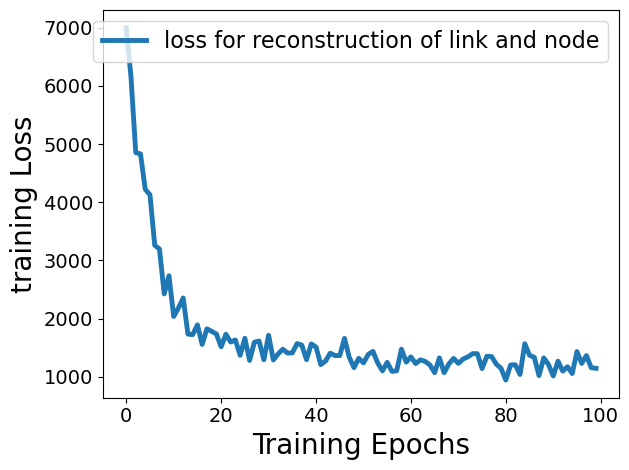

In [401]:
fig,ax = plt.subplots()
ax.plot(losslist,label='loss for reconstruction of link and node',linewidth=3.5)
ax.set_xlabel('Training Epochs',fontsize=20)
ax.set_ylabel('training Loss',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.legend(fontsize=16)
plt.grid(False)
plt.tight_layout()

In [402]:
PATH = '/home/yongcan/GDOT/clustering_kriging/save_models/CG-DGAE(DGCN)_r08.pth'
torch.save(DGCN.state_dict(),PATH)

In [12]:

DGCN2 = DGCN(h,y,z,w,K) 
DGCN2.to(device)
DGCN2.load_state_dict(torch.load('/home/yongcan/GDOT/clustering_kriging/save_models/CG-DGAE(DGCN)_r08.pth'))
DGCN2.eval()## Save the model

DGCN(
  (GNN1): D_GCN()
  (GNN2): D_GCN()
  (GNN3): D_GCN()
  (GNN4): D_GCN()
  (GNN5): D_GCN()
  (GNN6): D_GCN()
)

In [14]:
total_params

242528

In [13]:
total_params = sum(p.numel() for p in DGCN2.parameters())

# Assuming all parameters are of type float32 (4 bytes)
total_size_in_bytes = total_params * 4

# Convert to megabytes (optional)
total_size_in_megabytes = total_size_in_bytes / (1024 * 1024)

print(f'Total model size: {total_size_in_megabytes:.2f} MB')

Total model size: 0.93 MB


#### Testing 

In [7]:
### Introduce the test set, coming for 7 days 


X=[]
for station in stationname:
    values=[]
    fileaddress='/home/yongcan/GDOT/clustering_kriging/week_median_data/'+station+'.csv'
    station_df=pd.read_csv(fileaddress)
    for col in station_df.columns[1:8]:
        values += station_df[col].tolist()
    

    X.append(values)
    


X=np.array(X).astype(np.float32)

X.shape

(455, 2016)

In [8]:
testing_=X


pd.set_option('display.max_rows', 188)
cluster['cluster'].value_counts()

##找到每一类cluster的test node 的ID然后污染


1:103 ; 2:23; 3:119; 4:180 [145-0234_N]; 6:107; 8:2; 10:3; 12:4

In [9]:
testing_.shape

(455, 2016)

In [408]:
#cluster=pd.read_csv('/home/yongcan/GDOT/clustering_kriging/clustering_result_july13_revised.csv')
cluster_ID = set(cluster['cluster'])

In [417]:

time_dim = DGCN2.time_dimension
o_reconstructed = np.zeros([testing_.shape[1]//time_dim*time_dim, testing_.shape[0]])
o_error = np.zeros([testing_.shape[1]//time_dim*time_dim, testing_.shape[0]])
#o_true = np.zeros([testing_set.shape[0]//time_dim*time_dim, testing_set.shape[1]])

for ID in cluster_ID:
    
    CLUSTER = cluster.loc[cluster['cluster'] == ID]  
    know_nodes = list(CLUSTER.index)

    clustered_nodes = [testing_[n] for n in know_nodes]
    X_= np.array(clustered_nodes).astype(np.float32)
    testing_set=X_.transpose()
    E_maxvalue = testing_set.max()
    label_set=X_.transpose().copy()


    test_inputs = label_set #要记得改回去train_test


    for idx in range(test_inputs.shape[1]):
        o2 = np.zeros([testing_set.shape[0]//time_dim*time_dim, test_inputs.shape[1]])
        errors = np.zeros([testing_set.shape[0]//time_dim*time_dim, test_inputs.shape[1]]) #Separate the test data into several h period
        for i in range(0, testing_set.shape[0]//time_dim*time_dim, time_dim):
            E_inputs= introduce_error(testing_set[i:i+time_dim, :].transpose()[idx])
            testing_set[i:i+time_dim, idx]= E_inputs
            inputs = testing_set[i:i+time_dim,:]
            
            A_s=adj
            T_inputs = inputs/E_maxvalue
            T_inputs = np.expand_dims(T_inputs, axis = 0)
            T_inputs = torch.from_numpy(T_inputs.astype('float32')).to(device)
            A_s = A_s[list(know_nodes), :][:, list(know_nodes)]
            A_q = torch.from_numpy((calculate_random_walk_matrix(A_s).T).astype('float32')).to(device)
            A_h = torch.from_numpy((calculate_random_walk_matrix(A_s.T).T).astype('float32')).to(device)

            imputation2 = DGCN2(T_inputs, A_q, A_h)
            imputation2 = imputation2*E_maxvalue
            imputation2 = imputation2.data.cpu().numpy()

            #o1[i:i+time_dim, :] = imputation1
            o2[i:i+time_dim, :] = imputation2
            errors[i:i+time_dim,:] = inputs
        o_reconstructed[:,know_nodes[idx]]=o2[:,idx]
        o_error[:,know_nodes[idx]]=errors[:,idx]

#truth = test_inputs[0:test_set.shape[0]//time_dim*time_dim][:, list(know_nodes)]
#truth = test_inputs[0:label_set.shape[0]//time_dim*time_dim]
   
#o[missing_index_s[:, list(know_nodes)][0:test_set.shape[0]//time_dim*time_dim] == 1] = truth[missing_index_s[:, list(know_nodes)][0:test_set.shape[0]//time_dim*time_dim] == 1]
#test_mask =  1 - missing_index_s[0:test_set.shape[0]//time_dim*time_dim]

### Testing with artifical error sequence

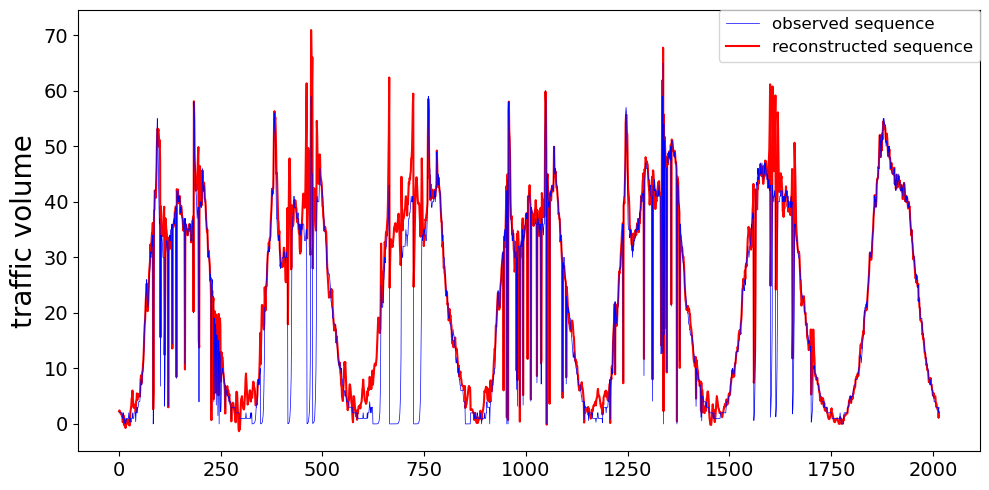

In [418]:

fig,ax = plt.subplots(figsize = (10,5))


#ax.plot(training_[0][288*0:288*13],label= 'observed sequence',linewidth=0.5,zorder=10,c='blue')
ax.plot(o_error[288*0:288*7,1],label= 'observed sequence',linewidth=0.5,zorder=10,c='blue')
ax.plot(o_reconstructed[288*0:288*7,1],label='reconstructed sequence',linewidth = 1.5,color='red',zorder=0)
#ax.axis('off')
ax.set_ylabel('traffic volume',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
#ax.set_xticklabels(['0:00\nMar 3rd','4:00','8:00','12:00','16:00','20:00','0:00\nMar 4th'])
ax.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0,fontsize=12)
plt.tight_layout()
#plt.savefig('fig/metr_ignnk_temporal.pdf')
plt.show()



In [419]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

In [420]:
RMSE=[]
MAE=[]
#MAPE=[]
true = testing_.transpose()
for i in range(true.shape[1]):
    y_true = true[288*0:288*7,i]
    y_pred = o_reconstructed[288*0:288*7,i]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    #mape = mean_absolute_percentage_error(y_true, y_pred)

    RMSE.append(rmse)
    MAE.append(mae)
  



#print(f"node counts: {len(clustered_nodes)}")
print(f"MAE: {sum(MAE)/len(MAE)}")
#print(f"MAPE: {sum(MAPE)/len(MAPE)}%")
print(f"RMSE: {sum(RMSE)/len(RMSE)}")

MAE: 7.177902896835508
RMSE: 16.47747686128528


NameError: name 'df' is not defined

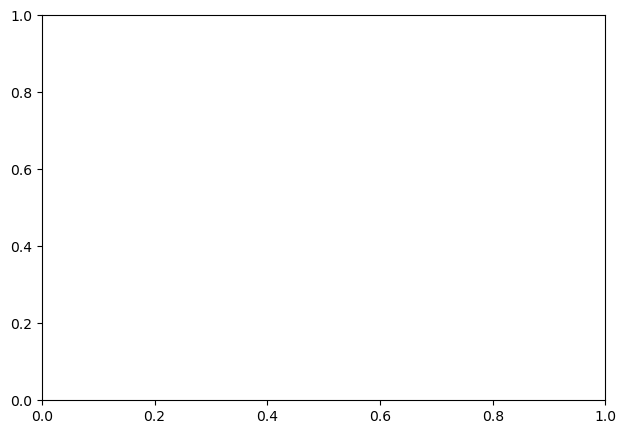

In [356]:

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df,bins=100)
plt.show()



In [78]:
input_sequence=errors[288*14:288*15,1].copy()

In [79]:
error=errors[288*14:288*15,1]-o2[288*14:288*15,1]


In [80]:
df=pd.DataFrame(error, columns=['Error'])
df['Location']=df.index


In [81]:
df

,Error,Location
0,-1.450535,0
1,-1.690377,1
2,-1.536027,2
3,-1.380871,3
4,-1.074669,4
...,...,...
283,-0.044349,283
284,-0.194733,284
285,-0.382486,285
286,-0.466587,286


In [82]:
def modified_zscore(data, consistency_correction=1.4826):

    median = np.median(data)

    deviation_from_med = np.array(data)-median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)

    return mod_zscore, mad

In [83]:
score_group = modified_zscore(df['Error'], consistency_correction=1.4826)

In [84]:
df_score=pd.DataFrame(score_group[0], columns=['score'])
df_score['Location']=df_score.index
df_score

,score,Location
0,-1.323125,0
1,-1.608472,1
2,-1.424837,2
3,-1.240243,3
4,-0.875946,4
...,...,...
283,0.349855,283
284,0.170939,284
285,-0.052435,285
286,-0.152493,286


In [85]:
new_df = df_score['score'][(df_score['score']<=-8)]
new_df

109    -8.164897
110    -9.981557
111   -11.779777
112   -12.329307
113   -12.682643
114   -11.987397
115   -10.709541
116    -8.833414
184    -9.246472
185   -11.970052
186   -15.349951
187   -17.800882
188   -19.686560
189   -20.107966
190   -19.505673
191   -16.973423
192   -14.455058
193   -11.403478
194    -8.264216
252    -8.965295
253    -9.076907
254    -8.604797
Name: score, dtype: float64

In [86]:
# high=df['Error'].mean() + 100*df['Error'].std()
# low=df['Error'].mean() -1*df['Error'].std()
# #new_df = df['Error'][(df['Error']<high) & (df['Error'] <low)]
# new_df = df['Error'][(df['Error'] <low)]


In [87]:
list(new_df.index.values)

[109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 252,
 253,
 254]

In [88]:
time_series = input_sequence

In [89]:
indices_to_replace=list(new_df.index.values)
indices_to_replace

[109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 252,
 253,
 254]

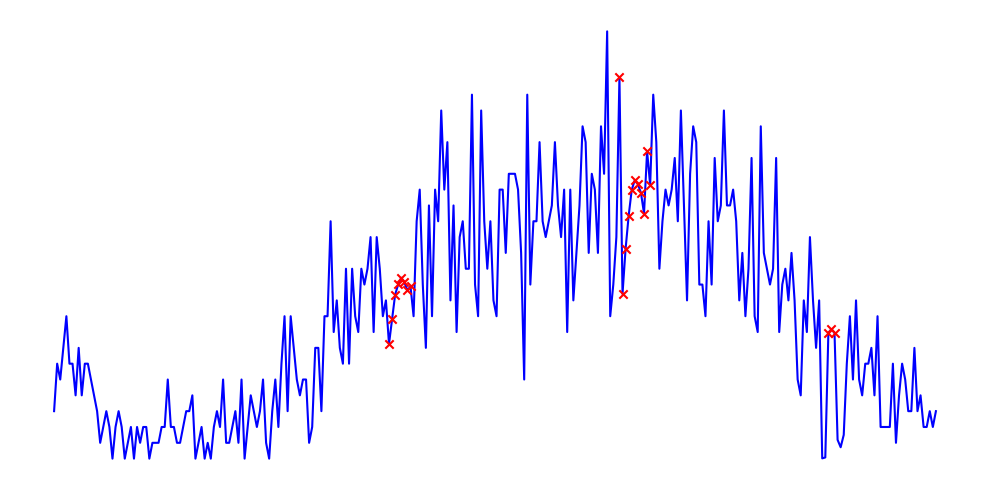

In [93]:
# Create an example time series (numpy array)


# Define the indices of the points you want to replace
indices_to_replace = list(new_df.index.values)  # Replace points at index 1 and 3


# Define the new values you want to replace with
new_values = o2[288*14:288*15,1][indices_to_replace]

# Update the time series array with the new values at the specified indices
time_series[indices_to_replace] = new_values

fig,ax = plt.subplots(figsize = (10,5))
ax.plot(time_series,label='Input Sequence',linewidth=1.5,zorder=5,color='blue')

#ax.plot(insert_zero(truth[288*4:288*5,3]),label= 'Faulty Timeseries', color='r',linewidth=1,zorder=0)
plt.scatter(indices_to_replace, new_values, color='red', marker='x',label='Replaced Points',zorder=10)
#ax.plot(o[288*4:288*5,3],label='Kriging Results',linewidth = 3,zorder=10,color='orange')
ax.axis('off')

# ax.set_ylabel('CCS Counts',fontsize=20)
# ax.tick_params(axis="x", labelsize=14)
# ax.tick_params(axis="y", labelsize=14)
# #ax.set_xticklabels(['0:00\nMar 3rd','4:00','8:00','12:00','16:00','20:00','0:00\nMar 4th'])
# ax.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0,fontsize=12)
plt.tight_layout()
#plt.savefig('fig/metr_ignnk_temporal.pdf')
plt.show()



# # Plot the original time series
# plt.plot(time_series, marker='o', label='Original Time Series',zorder=0)

# # Plot the replaced points with a different marker or color
# plt.scatter(indices_to_replace, new_values, color='red', marker='x', label='Replaced Points',zorder=10)

# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Time Series with Replaced Points')
# plt.legend()
# plt.show()

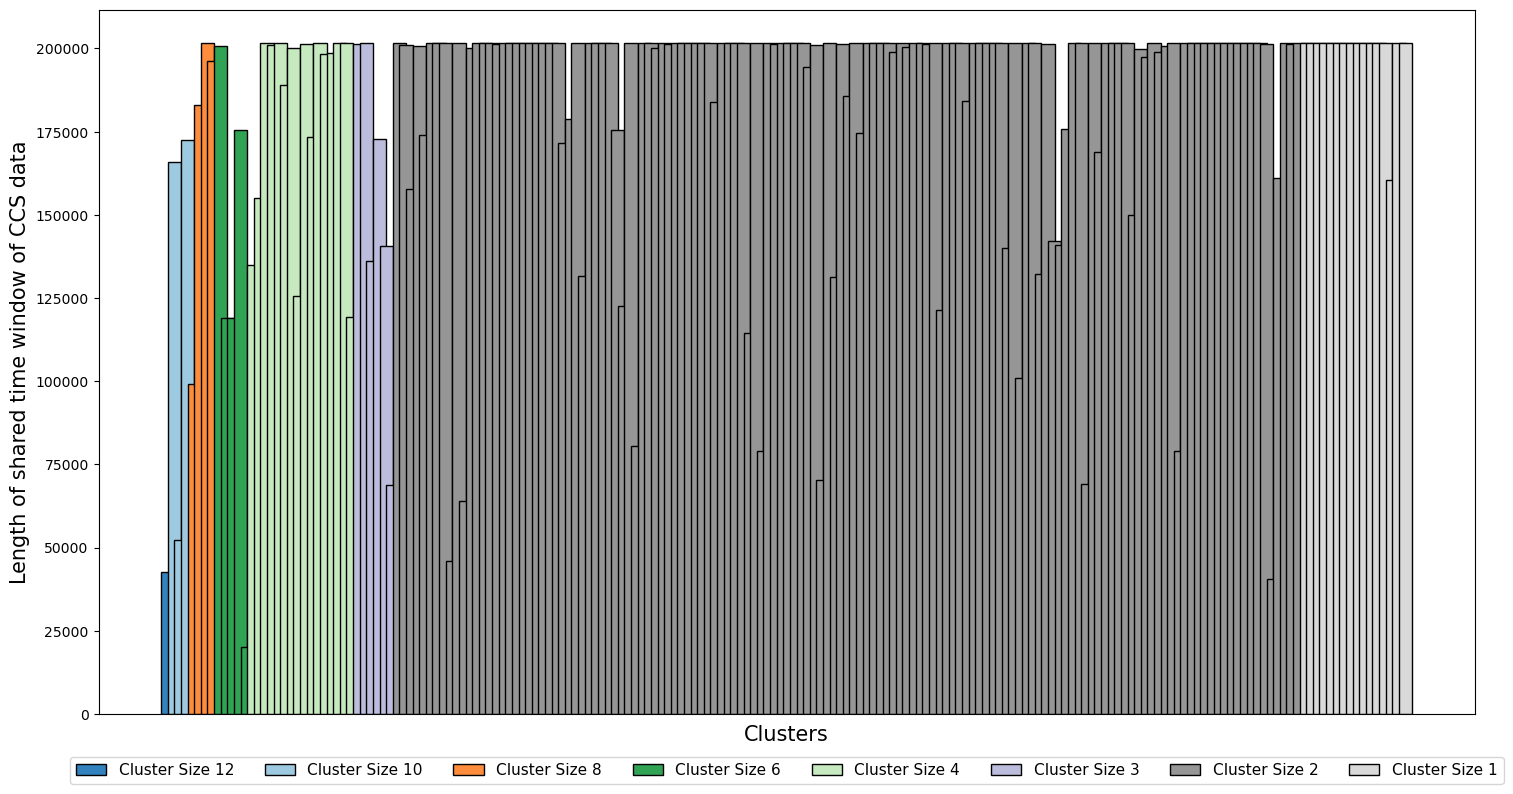

In [19]:
Data_resource= pd.read_csv('/home/yongcan/GDOT/clustering_kriging/cluster_counts.csv')


cluster_sizes = np.sort(Data_resource['cluster_size'].unique())[::-1]
colors = plt.cm.tab20c(np.linspace(0, 1, len(cluster_sizes)))

# Increase figure width for better spacing
fig, ax = plt.subplots(figsize=(16, 8))

# Group data by cluster_size and plot
for size, color in zip(cluster_sizes, colors):
    # Filter data for each cluster_size
    grouped_data = Data_resource[Data_resource['cluster_size'] == size]

    # Plot each group with its color and distinguished borders
    bars = ax.bar(grouped_data['cluster_ID'].astype(str), grouped_data['Length'], width=2, color=color, edgecolor='black', linewidth=1, label=f'Cluster Size {size}')

    # Add a single label for each subgroup with a rotation
    # for i, bar in enumeratshare(bars):
    #     if i == 0:  # Add label only to the first bar of each group
    #         ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{size}', ha='center', va='bottom', rotation=90, fontsize=8)

# Add labels and title
ax.set_xlabel('Clusters',fontsize=15,fontstyle='normal' ) #fontweight='bold'
ax.set_ylabel('Length of shared time window of CCS data',fontsize=15,fontstyle='normal')


# Turn off x-ticks
ax.set_xticks([])

# Place the legend outside the plot area
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(cluster_sizes), fontsize=11)

# Adjust layout to make room for the legend
plt.tight_layout()

# Show plot
plt.show()